# Interval Arithmetic in PyMC

Computational methods for enclosing the range of functions find their origins in interval analysis back in the early 1960s ([Moore, 1966](http://books.google.co.uk/books/about/Interval_analysis.html?id=csQ-AAAAIAAJ&redir_esc=y2); [Moore _et al._, 2009](http://books.google.co.uk/books/about/Introduction_to_interval_analysis.html?id=tT7ykKbqfEwC&redir_esc=y)). For functions whose expressions can be broken down into a finite number of elementary unary and binary operations, herein refered to as factorable functions, interval bounding can be readily automated. Popular libraries include [Boost](https://www.boost.org/doc/libs/1_86_0/libs/numeric/interval/doc/interval.htm), [PROFIL/BIAS](https://www.tuhh.de/ti3/software/profil.shtml) and [FILIB++](https://www2.math.uni-wuppertal.de/wrswt/software/filib.html). A default, non-verified implementation of inteval arithmetic is also provided in [MC++](https://github.com/omega-icl/mcpp). PyMC provides a python interface to one of these libraries depending on the compilation options used.

## Performing Interval Computations in PyMC

Suppose we want to calculate bounds on the range of the real-valued function $f(x,y)=x(\exp(x)-y)^2$ for $(x,y)\in [-2,1]\times[-1,2]$.

We start by importing the PyMC library:

In [2]:
import pymc


Then, we proceed by defining the ranges of both variables $x$ and $y$:

In [3]:
xI, yI = pymc.Interval(-2,1), pymc.Interval(-1,2)
print(xI,yI)

[ -2.0000000000000000e+00 :  1.0000000000000000e+00 ] [ -1.0000000000000000e+00 :  2.0000000000000000e+00 ]


### Using Operator Overloading

With operator overloading, we can simply compute the corresponding bounds on the range of $f$ as follows:

In [4]:
fI = xI*(pymc.exp(xI)-yI)**2
print(fI)

[ -2.7651239511697487e+01 :  1.3825619755848743e+01 ]


The lower and upper limits of an interval can be set or retrieved using the members `l` and `u`, respectively:

In [5]:
fl, fu = fI.l, fI.u
print(fl,fu)

-27.651239511697487 13.825619755848743


In [5]:
xI.l = -2.5
print(xI)
fI = xI*(pymc.exp(xI)-yI)**2
print(fI)

[ -2.5000000000000000e+00 :  1.0000000000000000e+00 ]
[ -3.4564049389621864e+01 :  1.3825619755848743e+01 ]


### Using Expression Trees

We start by constructing a DAG of $f$ (cf. [Other notebook](./ffunc.ipynb)):

In [6]:
DAG = pymc.FFGraph()
X, Y = pymc.FFVar(DAG,"x"), pymc.FFVar(DAG,"y")
F = X*(pymc.exp(X)-Y)**2
F.set("f")
DAG.output(DAG.subgraph([F]))


OPERATIONS IN SUBGRAPH:
  x	<-  VARIABLE
  Z0	<<  EXP( x )	
  y	<<  VARIABLE
  Z1	<<  Z0 - y	
  Z2	<<  SQR( Z1 )	
  f	<<  x x Z2	
DEPENDENTS IN SUBGRAPH:
  0:  f
WORK ARRAY SIZE: 6


Then, we evaluate the DAG using interval arithmetic:

In [7]:
[fI] = DAG.eval([F], [X,Y], [xI,yI])
print(fI)

[ -3.4564049389621864e+01 :  1.3825619755848743e+01 ]


### Visualization

A 3d plot of the function that shows both lower and upper bounds on its range is constructed below. Notice how the upper bound is tight, but the lower bound is very conservative.

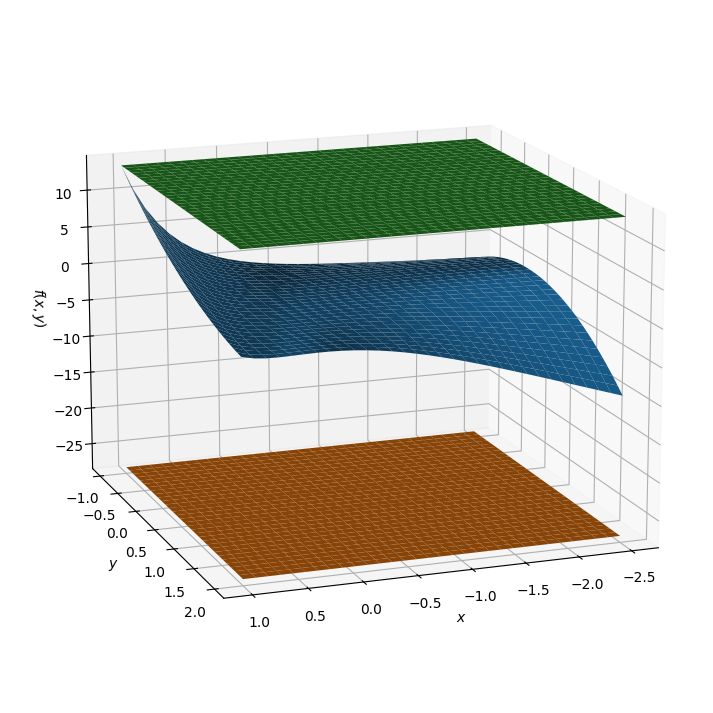

In [8]:
import numpy as np
import matplotlib.pyplot as plt

matx = np.outer(np.linspace(xI.l, xI.u, 32), np.ones(32))
maty = np.outer(np.ones(32), np.linspace(yI.l, yI.u, 32))
matf = matx*(np.exp(matx)-maty)**2
matfl = np.outer(np.ones(32), np.ones(32))*fl
matfu = np.outer(np.ones(32), np.ones(32))*fu

fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$f(x,y)$')

ax.plot_surface(matx, maty, matf)
ax.plot_surface(matx, maty, matfl)
ax.plot_surface(matx, maty, matfu)
ax.view_init(elev=15, azim=70)

plt.show()